In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

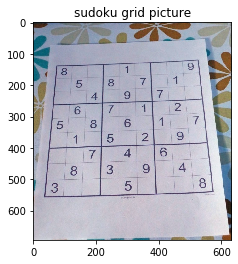

In [2]:
# Load an color image in grayscale
img = cv2.imread('images/picture_2.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.title('sudoku grid picture')
plt.show()

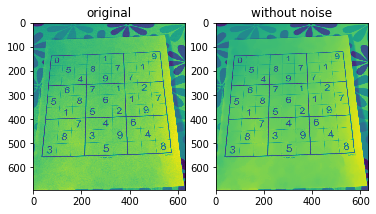

In [3]:
denoised_img = cv2.fastNlMeansDenoising(gray)

plt.subplot(121),plt.imshow(gray)
plt.title('original')
plt.subplot(122),plt.imshow(denoised_img)
plt.title('without noise')
plt.show()

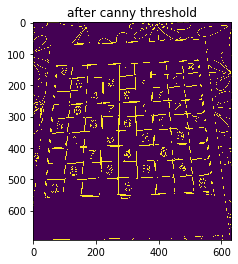

In [4]:
edges = cv2.Canny(denoised_img,10,150,apertureSize = 3)

plt.imshow(edges)
plt.title('after canny threshold')
plt.show()

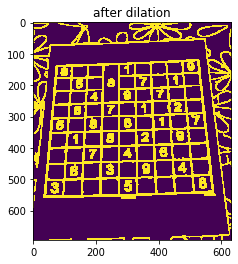

In [5]:
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(edges,kernel,iterations = 2)

plt.imshow(dilation)
plt.title('after dilation')
plt.show()

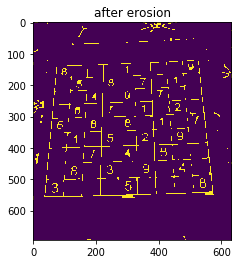

In [6]:
kernel = np.ones((7,7),np.uint8)
erosion = cv2.erode(dilation,kernel,iterations = 1)

plt.imshow(erosion)
plt.title('after erosion')
plt.show()

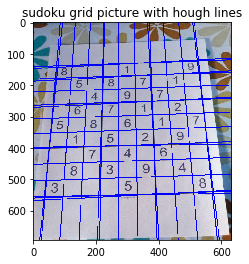

In [7]:
lines = cv2.HoughLines(erosion,1,np.pi/180,150)

for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    
cv2.imwrite('images/result_hough_lines.jpg',img)
plt.imshow(img)
plt.title('sudoku grid picture with hough lines')
plt.show()

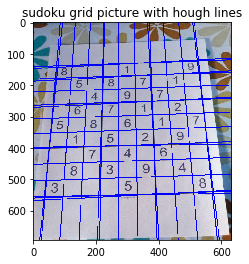

In [8]:
def detect_hough_lines(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    denoised_img = cv2.fastNlMeansDenoising(gray)
    
    edges = cv2.Canny(denoised_img,5,150,apertureSize = 3)
    
    kernel = np.ones((3,3),np.uint8)
    edges = cv2.dilate(edges,kernel,iterations = 1)
    
    kernel = np.ones((5,5),np.uint8)
    edges = cv2.erode(dilation,kernel,iterations = 1)
    
    lines = cv2.HoughLines(erosion,1,np.pi/180,150)

    for i, line in enumerate(lines):
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)


img = cv2.imread('images/picture_2.jpeg')

detect_hough_lines(img)

#cv2.imwrite('images/result.jpg',img)
plt.imshow(img)
plt.title('sudoku grid picture with hough lines')
plt.show()

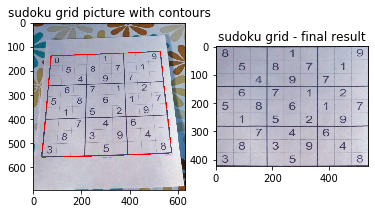

In [9]:
class SudokuGrid:
    
    def __init__(self, filepath):
        self.img = cv2.imread(filepath)
        self.gray = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        self.full_res_grid = None
        
    def find_edges(self):
        denoised_img = cv2.fastNlMeansDenoising(self.gray)
        return cv2.Canny(denoised_img,10,150,apertureSize = 3)
        
    def find_contours(self, edges):
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        biggest_contour = None
        biggest_contour_area = -1

        for contour in contours:
            contourArea = cv2.contourArea(contour)
            if contourArea > biggest_contour_area:
                biggest_contour_area = contourArea
                biggest_contour = contour
        
        if biggest_contour is not None:
            return biggest_contour, hierarchy
        
        return None
    
    def find_vertices(self, contours):
        # approximation of the grid shape
        epsilon = 0.1 * cv2.arcLength(contours, True)
        approx = cv2.approxPolyDP(contours,epsilon,True)
        
        pts = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype = "float32")
        
        # the top-left point has the smallest sum whereas the
        # bottom-right has the largest sum
        s = pts.sum(axis = 1)
        
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        
        # compute the difference between the points 
        # the top-right will have the minumum difference and
        # the bottom-left will have the maximum difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        
        return rect
    
    def warp(self, contours):
        vertices = self.find_vertices(contours)
        
        (top_left, top_right, bottom_right, bottom_left) = vertices
        
        # distance between the bottom right / bottom left points and top right / top left points
        widthA = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
        widthB = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
        
        # distance between the top right / bottom right points and top left / bottom left points
        heightA = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
        heightB = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))
        
        maxWidth = max(int(widthA), int(widthB))
        maxHeight = max(int(heightA), int(heightB))
        
        warped_vertices = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")
        
        M = cv2.getPerspectiveTransform(vertices, warped_vertices)
        warped = cv2.warpPerspective(self.img, M, (maxWidth, maxHeight))
        
        return warped
    
    def generate_full_res(self):
        
        edges = self.find_edges()
        contours, hierarchy = self.find_contours(edges)
        
        self.full_res_grid = self.warp(contours)
        
        cv2.drawContours(self.img, [contours], 0, (255, 0, 0), 2, cv2.LINE_8, hierarchy, 0)
        
        return self.full_res_grid
    
    def get_array(self, saveToFile=False):
        if self.full_res_grid is None:
            return
        
        box_width = int(self.full_res_grid.shape[1] / 9)
        box_height = int(self.full_res_grid.shape[0] / 9)
        
        array = []
        
        for i in range(9):
            array.append([])
            for j in range(9):
                x = j * box_width
                y = i * box_height
                cropped = self.full_res_grid[y:y+box_height, x:x+box_width]
                array[i].append(cropped)
                if saveToFile:
                    cv2.imwrite('images/result_{}_{}.jpg'.format(i,j), cropped)
        
        return array


sudoku_grid = SudokuGrid('images/picture_2.jpeg')

res = sudoku_grid.generate_full_res()

cv2.imwrite('images/result_0.jpg',sudoku_grid.img)
cv2.imwrite('images/result_1.jpg',res)

plt.subplot(121), plt.imshow(sudoku_grid.img)
plt.title('sudoku grid picture with contours')
plt.subplot(122), plt.imshow(res)
plt.title('sudoku grid - final result')
plt.show()

In [10]:
sudoku_array = sudoku_grid.get_array()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [11]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import numpy as np
import torchvision.transforms as transforms
import random

In [12]:
def preprocess_image(image, plot=False):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = image.shape 
    x1 = int(w / 5)
    y1 = int(h / 9)
    x2 = w - x1
    y2 = h - y1
    cropped = image[y1:y2, x1:x2]
    cropped = cv2.medianBlur(cropped,5)
    cropped = cv2.adaptiveThreshold(cropped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,2)
    if plot:
        plt.imshow(cropped)
        plt.show()
        
    return cropped

text:''


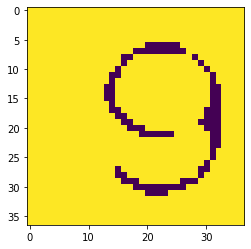

text:'9
'


In [13]:
from pytesseract import image_to_string
import pytesseract

pytesseract.pytesseract.tesseract_cmd = 'C:\\Users\\boris\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe'
# img = Image.open('images/test.jpg').convert('L')
#img = Image.open('images/result_0_8.jpg').convert('L')
img = cv2.imread('images/result_0_8.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#ret,img = cv2.threshold(np.array(img), 125, 255, cv2.THRESH_BINARY)
kernel = np.ones((3,3),np.uint8)
#img = cv2.dilate(img,kernel,iterations = 1)
# Older versions of pytesseract need a pillow image
# Convert back if needed
#img = Image.fromarray(img.astype(np.uint8))
img = preprocess_image(img)
print('text:\'{}\''.format(image_to_string(img, config='--psm 7 -c tessedit_char_whitelist=0123456789')))
img = cv2.dilate(img,kernel,iterations = 1)
plt.imshow(img)
plt.show()
print('text:\'{}\''.format(image_to_string(img, config='--psm 7 -c tessedit_char_whitelist=0123456789')))

In [14]:
def predict(path, plot=False):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if plot:
        plt.subplot(131), plt.imshow(img)
    img = preprocess_image(img)
    if plot:
        plt.subplot(132), plt.imshow(img)
    kernel = np.ones((3,3),np.uint8)
    img = cv2.erode(img,kernel,iterations = 1)
    if plot:
        plt.subplot(133), plt.imshow(img)
        plt.show()
    return int(image_to_string(img, config='--psm 7 -c tessedit_char_whitelist=0123456789')[0])

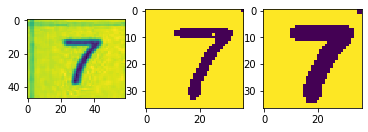

7

In [15]:
predict('images/result_1_5.jpg', plot=True)

In [16]:
def predict_v2(img, plot=False):
    if plot:
        plt.subplot(131), plt.imshow(img)
    img = preprocess_image(img)
    if plot:
        plt.subplot(132), plt.imshow(img)
    kernel = np.ones((3,3),np.uint8)
    img = cv2.erode(img,kernel,iterations = 1)
    if plot:
        plt.subplot(133), plt.imshow(img)
        plt.show()
    perc = 100 - (cv2.countNonZero(img)/(img.shape[0]*img.shape[1])*100)
    
    if perc < 12.0:
        return -1
    
    res = image_to_string(img, config='--psm 7 -c tessedit_char_whitelist=0123456789')
    if len(res) > 1:
        if res[:1].isnumeric():
            return int(res[0])
    elif res.isnumeric():
            return int(res[0])
    return -1

In [17]:
sudoku_grid = SudokuGrid('images/picture_2.jpeg')

res = sudoku_grid.generate_full_res()

array = sudoku_grid.get_array()

In [18]:
final_array = []
for i in range(9):
    a = []
    for j in range(9):
        r = predict_v2(array[i][j])
        if r == -1:
            a.append(' ')
        else:
            a.append(__builtins__.str(r))
    print(a)
    final_array.append(a)


['8', ' ', ' ', ' ', '4', ' ', ' ', ' ', ' ']
[' ', '5', ' ', '8', ' ', '7', ' ', ' ', ' ']
[' ', ' ', '4', ' ', ' ', ' ', '7', ' ', ' ']
[' ', '6', ' ', '7', ' ', ' ', ' ', '2', ' ']
['5', ' ', '8', ' ', '6', ' ', '1', ' ', '7']
[' ', ' ', ' ', '5', ' ', '2', ' ', '9', ' ']
[' ', ' ', '7', ' ', '4', ' ', '6', ' ', ' ']
[' ', '8', ' ', '3', ' ', ' ', ' ', '4', ' ']
['3', ' ', ' ', ' ', '5', ' ', ' ', ' ', '8']


In [19]:
def plot_grid_after_prep(array):
    kernel = np.ones((3,3),np.uint8)
    for i in range(9):
        for j in range(9):
            array[i][j] = preprocess_image(array[i][j])
            array[i][j] = cv2.erode(array[i][j],kernel,iterations = 1)
            plt.figure()
            plt.title(f'{100 - (cv2.countNonZero(array[i][j])/(array[i][j].shape[0]*array[i][j].shape[1])*100)}%')
            plt.imshow(array[i][j])
            plt.show()
    plt.show()

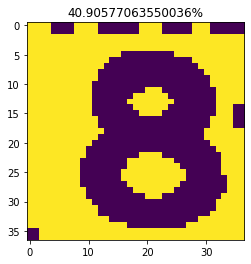

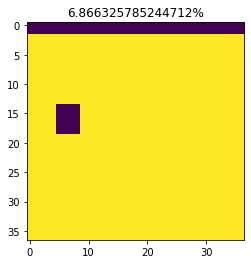

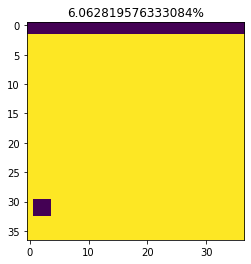

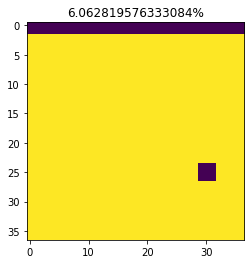

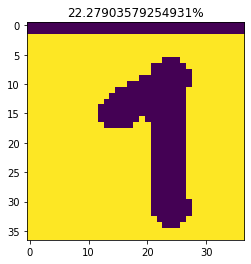

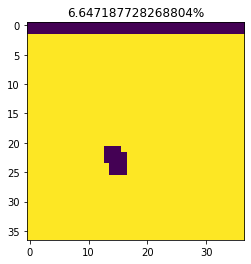

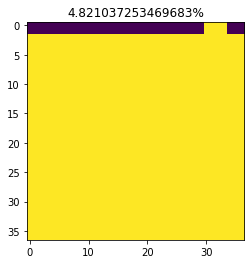

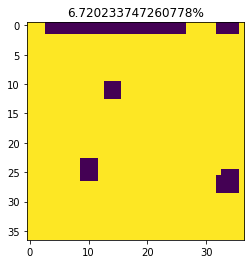

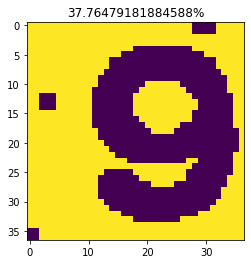

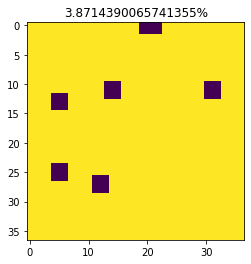

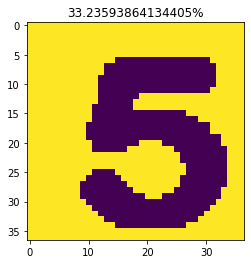

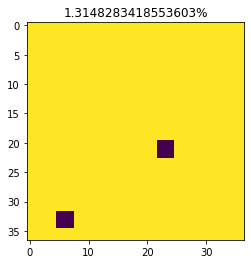

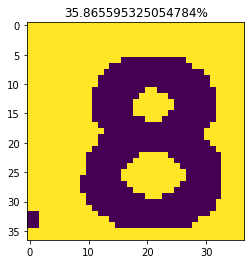

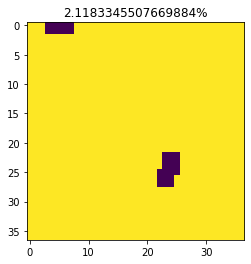

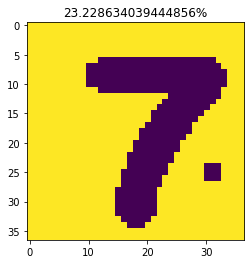

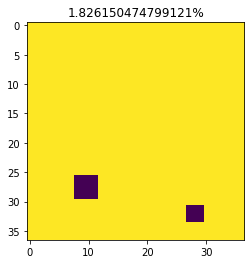

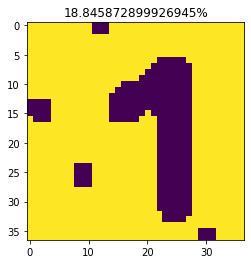

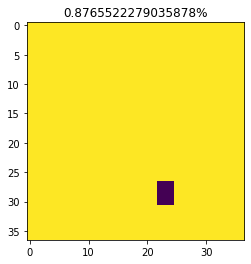

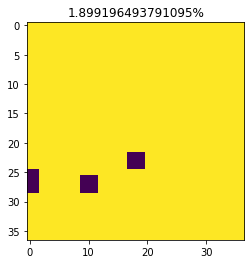

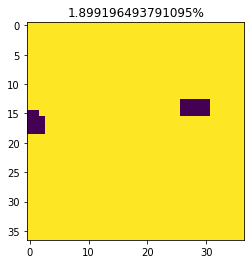

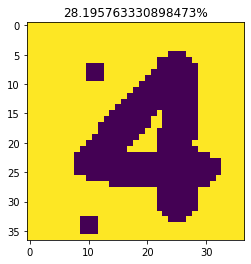

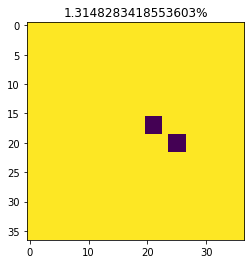

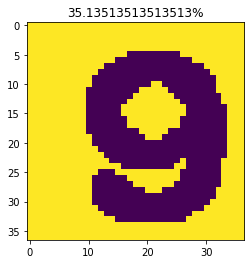

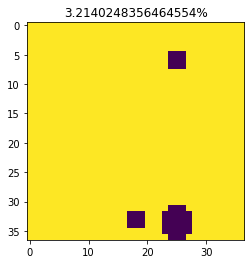

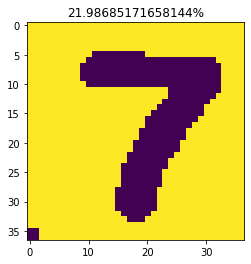

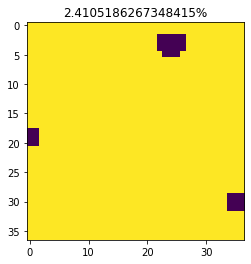

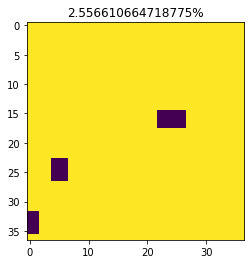

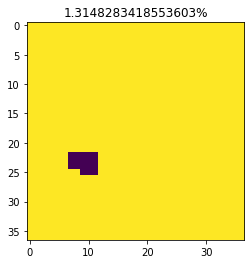

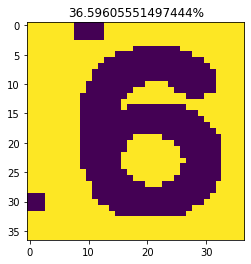

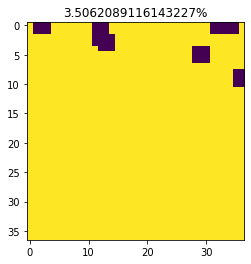

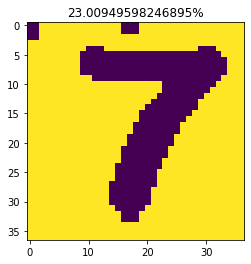

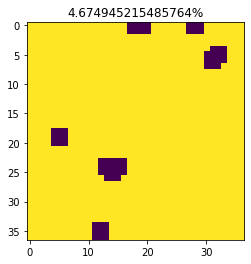

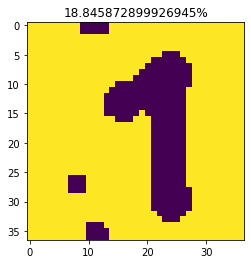

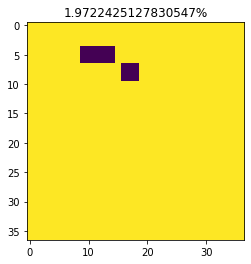

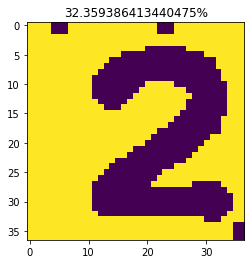

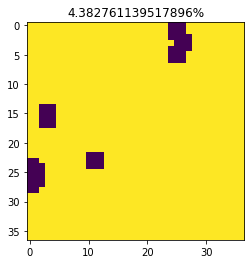

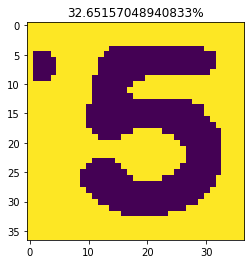

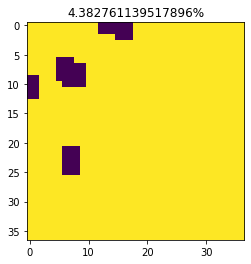

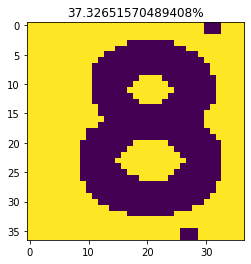

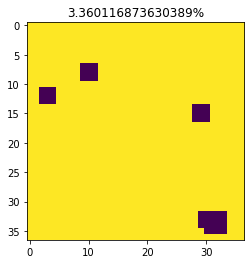

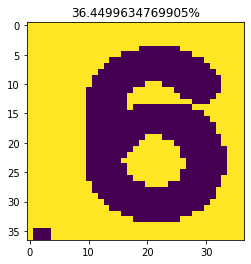

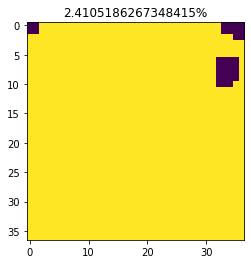

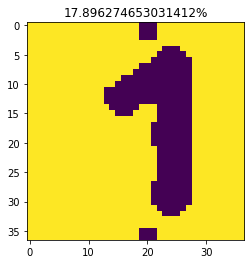

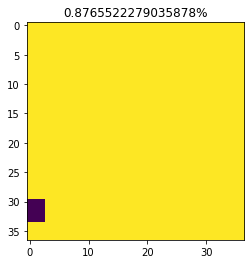

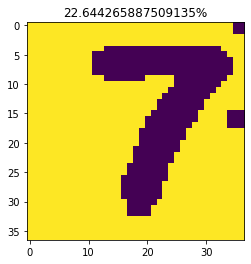

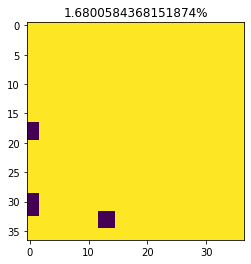

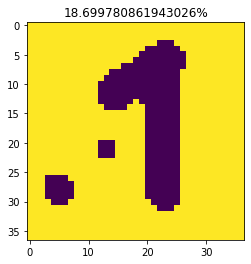

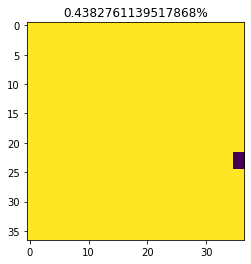

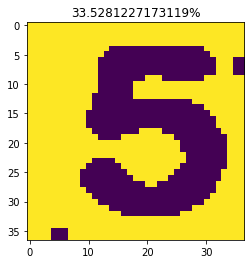

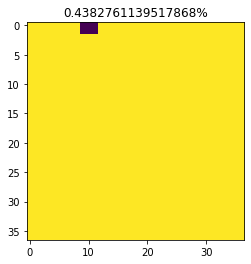

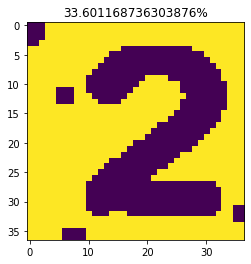

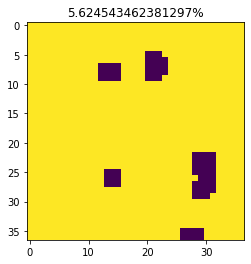

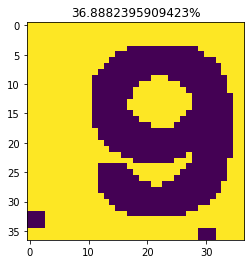

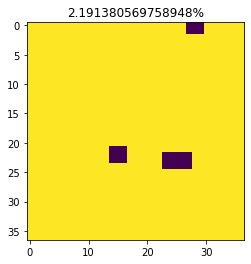

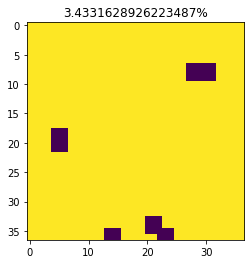

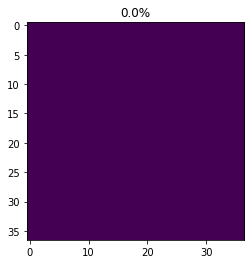

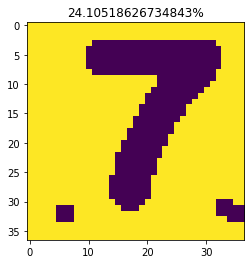

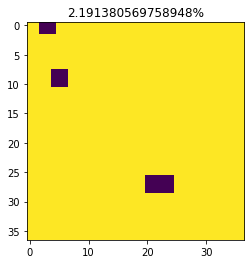

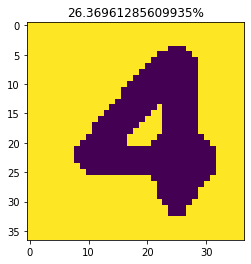

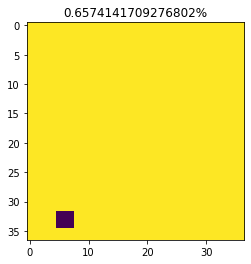

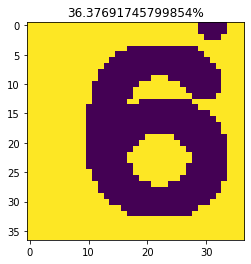

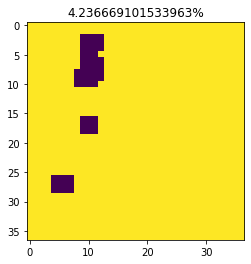

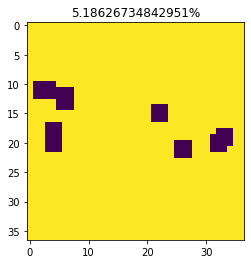

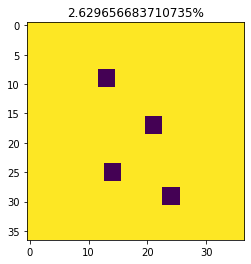

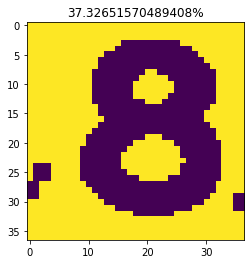

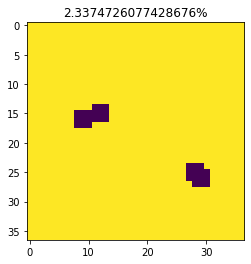

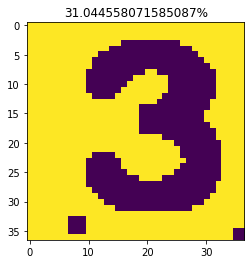

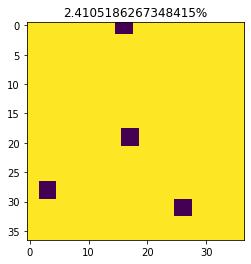

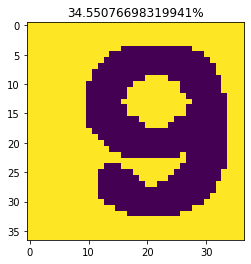

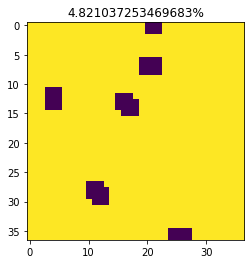

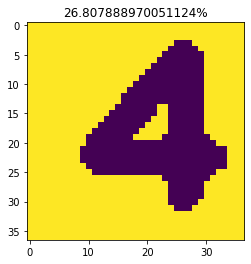

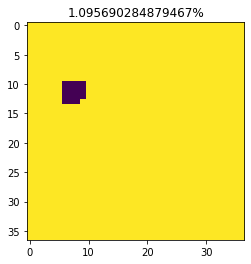

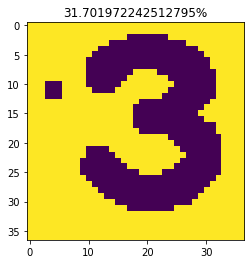

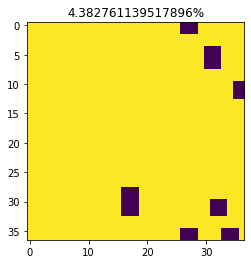

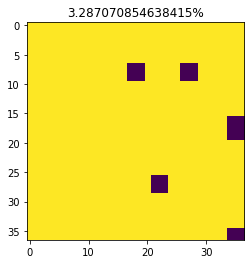

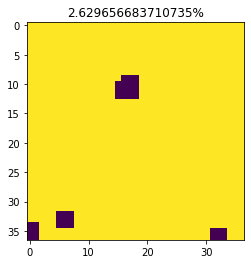

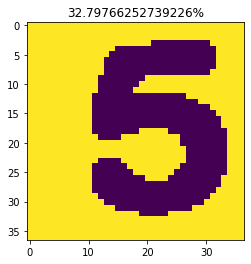

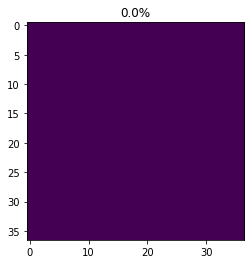

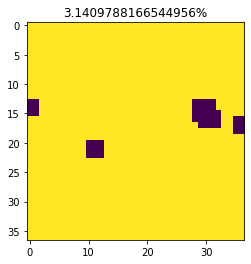

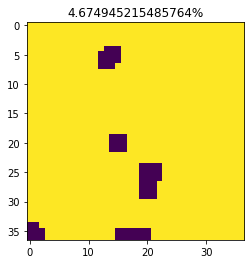

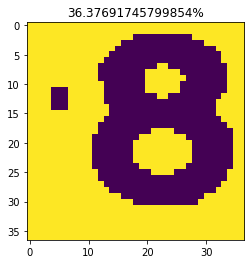

In [20]:
plot_grid_after_prep(array)

In [21]:
sudoku_grid = SudokuGrid('images/picture_2.jpeg')

res = sudoku_grid.generate_full_res()

array = sudoku_grid.get_array()

In [22]:
def find_number_contours(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    biggest_contour = None
    biggest_contour_area = -1
    second_biggest=None
    i=0

    for contour in contours:
        i+=1
        contourArea = cv2.contourArea(contour)
        if contourArea > biggest_contour_area:
            second_biggest=biggest_contour
            biggest_contour_area = contourArea
            biggest_contour = contour
    #print(f'nbr of contours : {i}')
    if second_biggest is not None:
        return second_biggest, hierarchy

    return None, None

def prep_v1(array, plot=False):
    kernel = np.ones((3,3),np.uint8)
    fill_color = [255,255,255] # any BGR color value to fill with
    mask_value = 255
    for i in range(9):
        for j in range(9):
            img = array[i][j]
            img = preprocess_image(img)
            img = cv2.erode(img,kernel,iterations = 1)
            contours, hierarchy = find_number_contours(img)
            img_color = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            if contours is not None and hierarchy is not None:
                #cv2.drawContours(img_color, [contours], 0, (255, 0, 0), 2, cv2.LINE_8, hierarchy, 0)
                stencil  = np.zeros(img_color.shape[:-1]).astype(np.uint8)
                cv2.fillPoly(stencil, [contours], mask_value)
                sel = stencil != mask_value # select everything that is not mask_value
                img_color[sel] = fill_color       
            if plot:
                plt.figure()
                plt.title(f'{100 - (cv2.countNonZero(img)/(img.shape[0]*img.shape[1])*100)}%')
                plt.imshow(img_color)
                plt.show()
    if plot:
        plt.show()

def prep_v2(image, plot=False):
    kernel = np.ones((3,3),np.uint8)
    fill_color = [255,255,255] # any BGR color value to fill with
    mask_value = 255
    img = image
    img = preprocess_image(img)
    img = cv2.erode(img,kernel,iterations = 1)
    contours, hierarchy = find_number_contours(img)
    img_color = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    ret=None
    if contours is not None and hierarchy is not None:
        #cv2.drawContours(img_color, [contours], 0, (255, 0, 0), 2, cv2.LINE_8, hierarchy, 0)
        stencil  = np.zeros(img_color.shape[:-1]).astype(np.uint8)
        cv2.fillPoly(stencil, [contours], mask_value)
        sel = stencil != mask_value # select everything that is not mask_value
        if (cv2.contourArea(contours) / (img.shape[0]*img.shape[1]))*100 >= 12:
            img_color[sel] = fill_color
        else:
            img_color[:] = fill_color
        ret = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    else:
        ret=img
    if plot:
        plt.figure()
        plt.title(f'{100 - (cv2.countNonZero(img)/(img.shape[0]*img.shape[1])*100)}%')
        plt.imshow(img_color)
        plt.show()
    return ret

In [23]:
def predict_v3(img, plot=False):
    
    img = prep_v2(img, plot)
    
    perc = 100 - (cv2.countNonZero(img)/(img.shape[0]*img.shape[1])*100)
    
    if perc < 12.0:
        return -1
    
    res = image_to_string(img, config='--psm 7 -c tessedit_char_whitelist=0123456789')
    if len(res) > 1:
        if res[:1].isnumeric():
            return int(res[0])
    elif res.isnumeric():
            return int(res[0])
        
    kernel = np.ones((3,3),np.uint8)
    # img = cv2.dilate(img,kernel,iterations = 1)
    
    res = image_to_string(img, config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
    if len(res) > 1:
        if res[:1].isnumeric():
            return int(res[0])
    elif res.isnumeric():
            return int(res[0])
    
    return -1

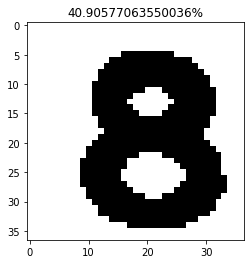

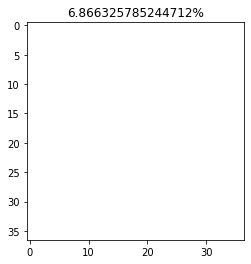

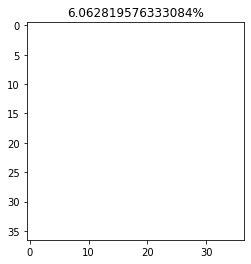

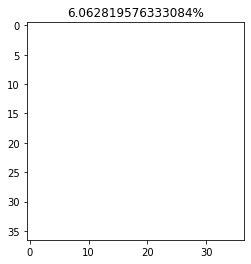

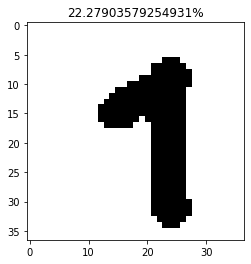

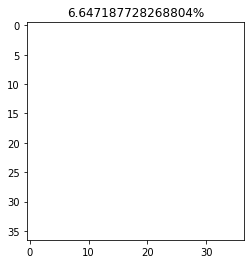

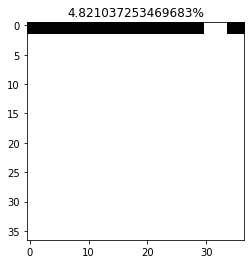

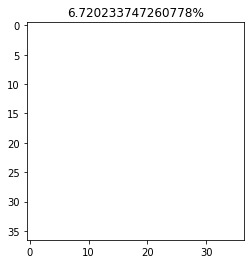

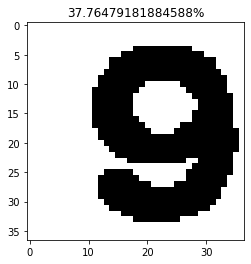

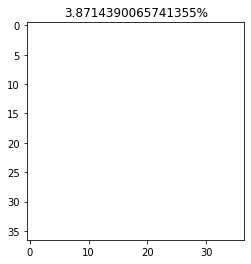

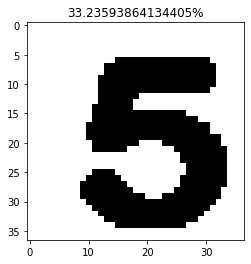

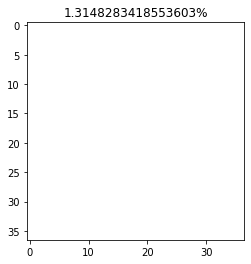

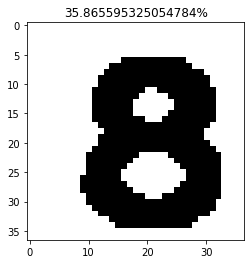

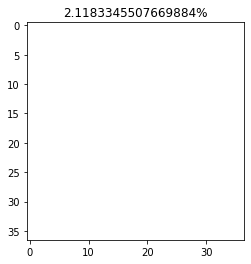

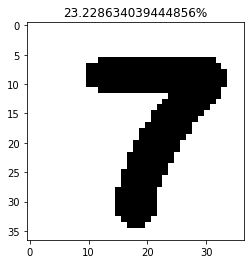

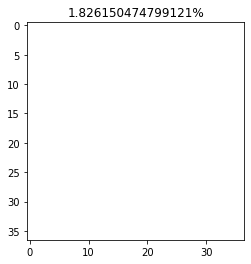

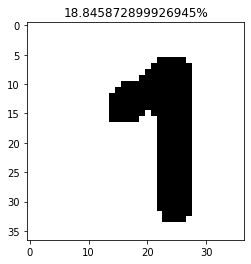

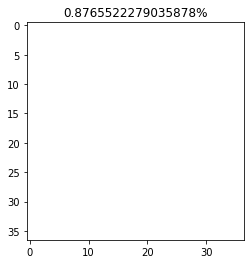

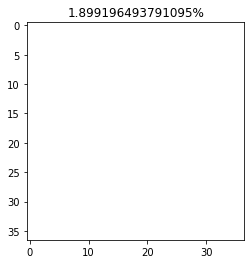

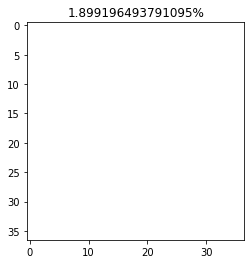

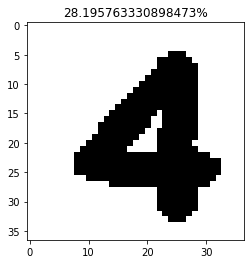

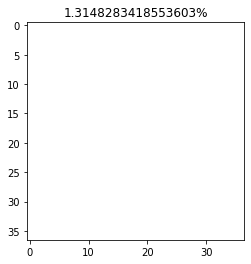

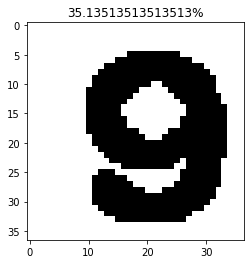

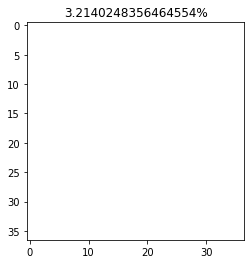

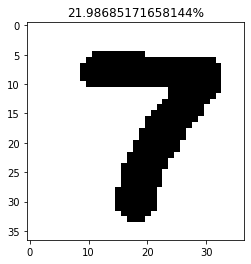

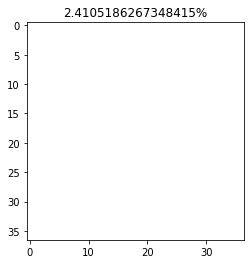

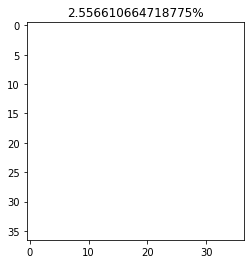

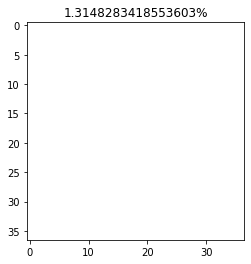

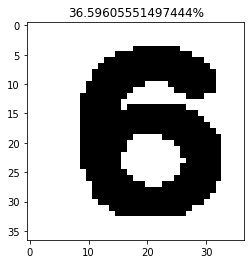

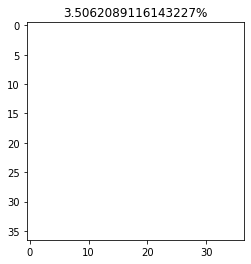

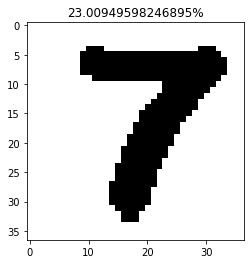

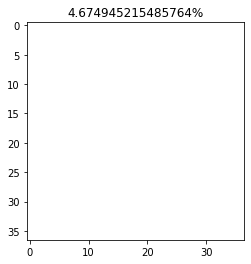

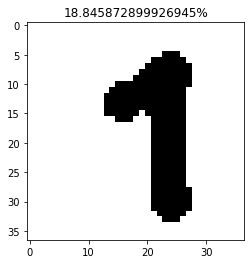

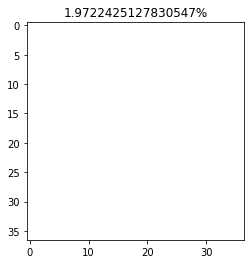

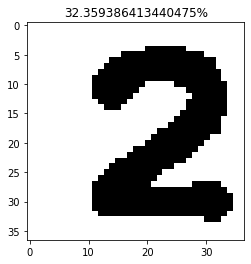

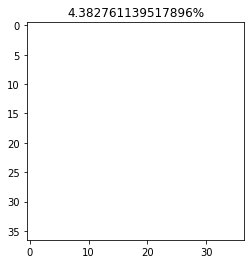

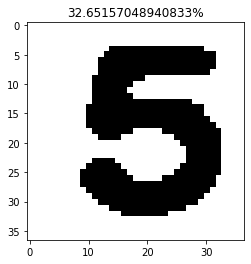

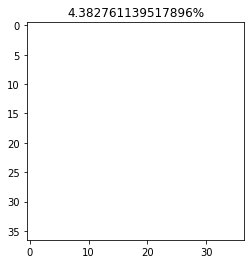

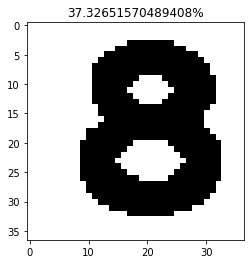

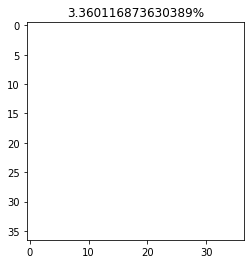

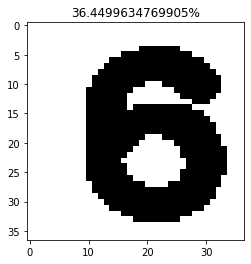

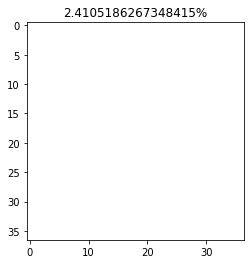

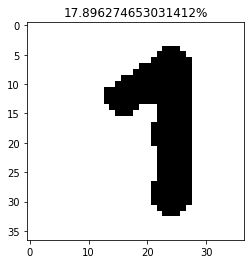

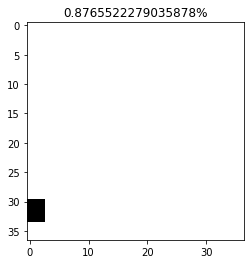

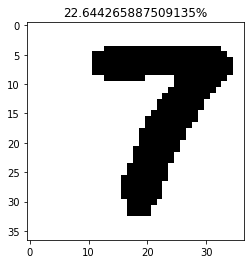

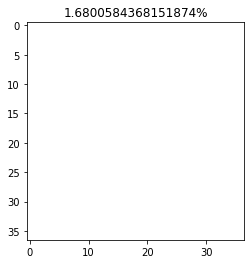

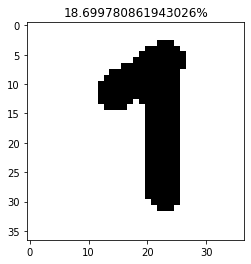

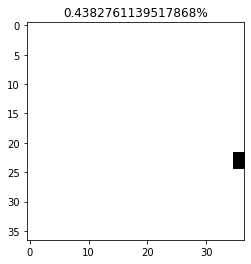

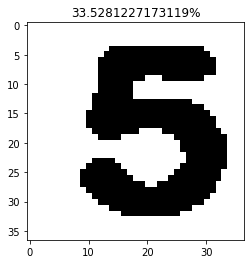

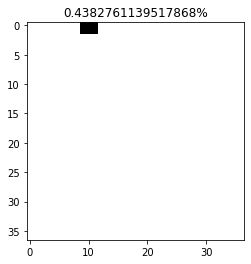

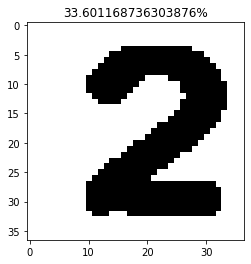

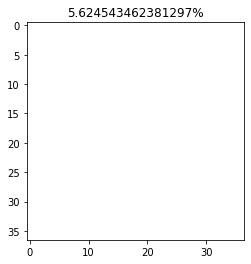

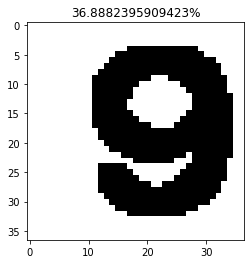

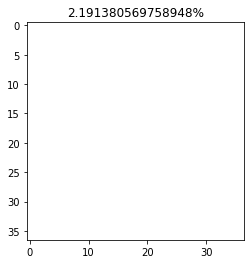

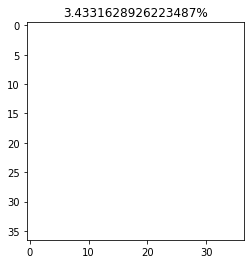

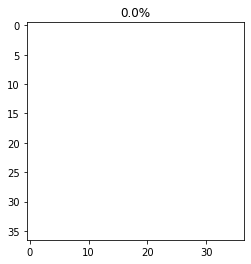

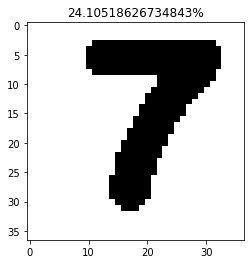

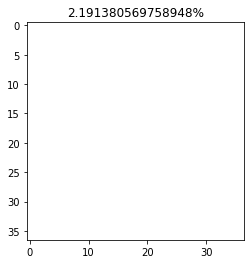

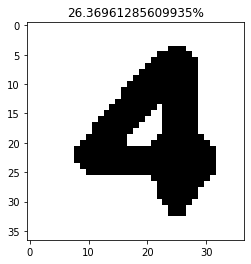

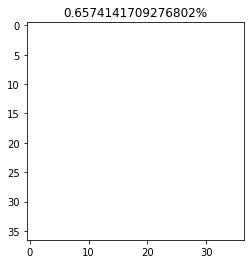

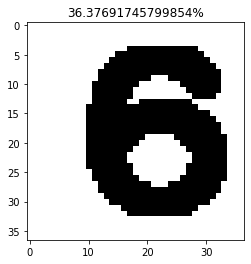

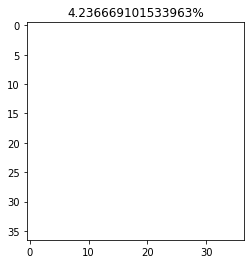

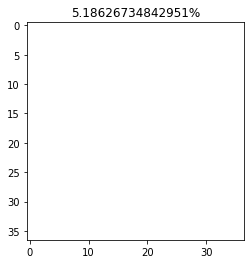

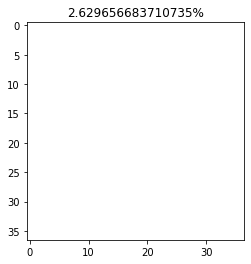

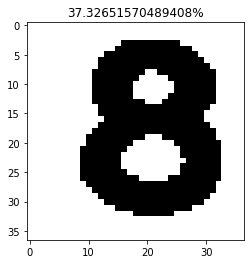

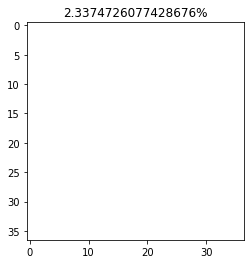

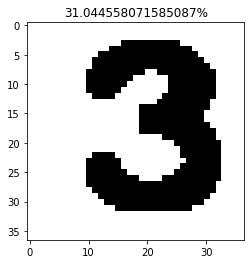

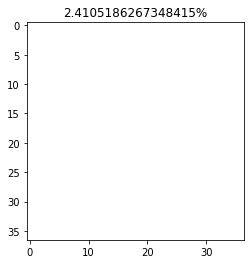

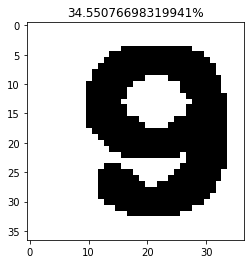

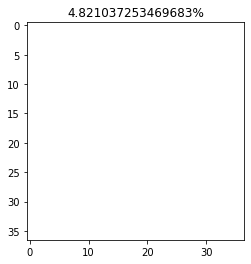

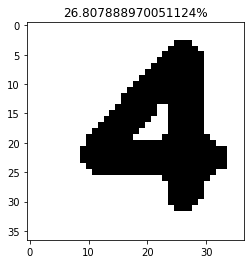

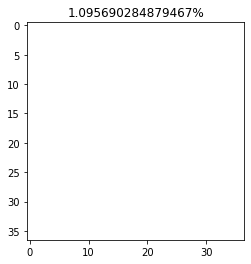

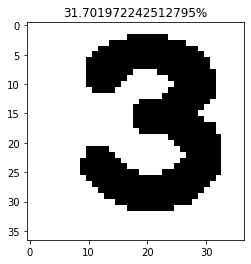

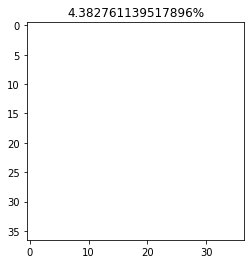

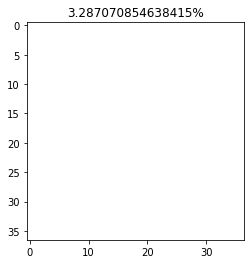

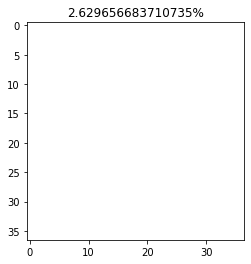

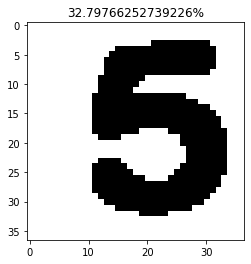

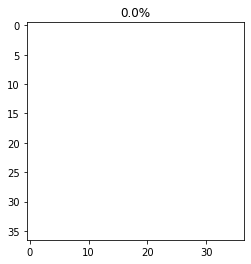

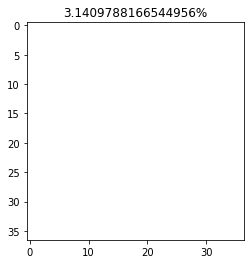

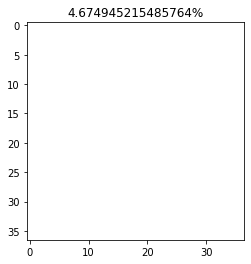

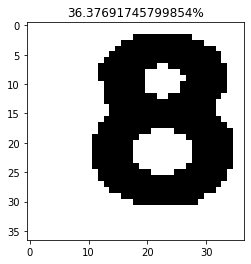

In [24]:
sudoku_grid = SudokuGrid('images/picture_2.jpeg')

res = sudoku_grid.generate_full_res()

array = sudoku_grid.get_array()

final_array = []
for i in range(9):
    a = []
    for j in range(9):
        r = predict_v3(array[i][j], plot=True)
        if r == -1:
            a.append(' ')
        else:
            a.append(__builtins__.str(r))
    # print(a)
    final_array.append(a)

['8', ' ', ' ', ' ', '1', ' ', ' ', ' ', '9']
[' ', '5', ' ', '8', ' ', '7', ' ', '1', ' ']
[' ', ' ', '4', ' ', '9', ' ', '7', ' ', ' ']
[' ', '6', ' ', '7', ' ', '1', ' ', '2', ' ']
['5', ' ', '8', ' ', '6', ' ', '1', ' ', '7']
[' ', '1', ' ', '5', ' ', '2', ' ', '9', ' ']
[' ', ' ', '7', ' ', '4', ' ', '6', ' ', ' ']
[' ', '8', ' ', '3', ' ', '9', ' ', '4', ' ']
['3', ' ', ' ', ' ', '5', ' ', ' ', ' ', '8']


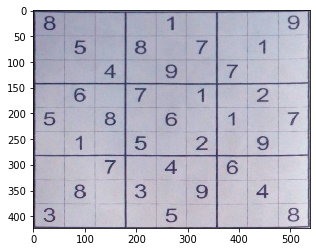

In [28]:
for row in final_array:
    print(row)

plt.imshow(sudoku_grid.full_res_grid)
plt.show()